# Model Evaluation Notebook

In [38]:
import torch
from torch.utils.data import DataLoader
from pathlib import Path
from dataset import Paint2CodeDataset
from utils import collate_fn, ids_to_tokens, generate_visualization_object, img_transformation
from models import Encoder, Decoder
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from tqdm import tqdm
import pickle
from GUIconverter.GUIconverter import GUIconverter
from IPython.display import display, HTML, Image

In [39]:
# Configuration parameters
model_file_path = "./models/ED--epoch-24--loss-0.03463.pth"  # Update with actual path
data_path = Path("data", "all_data")
use_cuda = True
img_crop_size = 224
split = "validation"
batch_size = 4
seed = 42

In [40]:
# Set random seeds for reproducibility
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Setup GPU
device = torch.device("cuda" if torch.cuda.is_available() and use_cuda else "cpu")
print(f"Using device: {device}")

# Ensure the model file exists
assert Path(model_file_path).exists(), "Model file path does not exist"

Using device: cuda


In [41]:
# Load the saved model
loaded_model = torch.load(model_file_path, map_location=device)
vocab = loaded_model["vocab"]

assert vocab is not None, "Vocabulary must be loaded."
len(vocab)

17

In [42]:
# Initialize the models
embed_size = 256
hidden_size = 512
num_layers = 1

encoder = Encoder(embed_size).to(device)
decoder = Decoder(embed_size, hidden_size, len(vocab), num_layers).to(device)

# Load model weights
encoder.load_state_dict(loaded_model["encoder_model_state_dict"])
decoder.load_state_dict(loaded_model["decoder_model_state_dict"])

encoder.eval()
decoder.eval()
print("Model loaded and set to evaluation mode.")

Model loaded and set to evaluation mode.


In [43]:
# Image transformations
transform_imgs = img_transformation(img_crop_size)

# Data loader
data_loader = DataLoader(
    Paint2CodeDataset(data_path, split, vocab, transform=transform_imgs),
    batch_size=batch_size,
    collate_fn=lambda data: collate_fn(data, vocab=vocab),
    pin_memory=True if use_cuda else False,
    drop_last=True)

In [44]:
# Evaluate the model and calculate BLEU score
predictions = []
targets = []

for i, (image, caption) in enumerate(tqdm(data_loader.dataset)):
    image = image.to(device)
    caption = caption.to(device)
    features = encoder(image.unsqueeze(0))
    sample_ids = decoder.sample(features).cpu().data.numpy()
    
    predictions.append(ids_to_tokens(vocab, sample_ids))
    targets.append(ids_to_tokens(vocab, caption.cpu().numpy()))

bleu_score = corpus_bleu([[target] for target in targets], predictions, smoothing_function=SmoothingFunction().method4)
print(f"BLEU score: {bleu_score:.4f}")

  0%|          | 0/339 [00:00<?, ?it/s]

100%|██████████| 339/339 [00:29<00:00, 11.49it/s]

BLEU score: 0.9218


In [45]:
generate_visualization_object(data_loader.dataset, predictions, targets)
print("Visualization objects generated.")

PATH_VIS_OBJ = Path("tmp_sequenсes.pkl")

with open(PATH_VIS_OBJ, 'rb') as handle:
    viz_obj = pickle.load(handle)
    
predictions = viz_obj["predictions"]
targets = viz_obj["targets"]
targets_filepaths = viz_obj["targets_filepaths"]

assert predictions and targets and targets_filepaths

Visualization objects generated.


In [46]:
def display_html_string(html_string):
    page = HTML(html_string)
    display(page)

def compare_results(predicted_labels, actual_labels, actual_img_path):
    transpiler = GUIconverter(style='style1')

    print(f'Predicted HTML. #tokens: {len(predicted_labels)}')
    predicted_html_string = transpiler.transpile(predicted_labels, insert_random_text=True)
    print(predicted_html_string)
    display_html_string(predicted_html_string)
    
    print(f'Actual image file')
    display(Image(str(actual_img_path))) 

Predicted HTML. #tokens: 56
<html>
  <header>
    <meta charset="utf-8">
    <meta name="viewport" content="width=device-width, initial-scale=1">
<link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.3/dist/css/bootstrap.min.css" integrity="sha384-QWTKZyjpPEjISv5WaRU9OFeRpok6YctnYmDr5pNlyT2bRjXh0JMhjY6hW+ALEwIH" crossorigin="anonymous">
<style>
.body { background-color: #212529; }
.header { margin: 20px 0; }
nav ul.nav-pills li { background-color: #9ef9ff;font-size: 20px; border-radius: 4px; margin: 10px; padding: 10px; text-decoration: none; }
.col-lg-3 { width: 24%; margin-right: 1.333333%; }
.col-lg-6 { width: 49%; margin-right: 2%; }
.col-lg-12, .col-lg-3, .col-lg-6 { margin-bottom: 20px; border-radius: 6px; background-color: #f5f5f5; padding: 20px; }
.row .col-lg-3:last-child, .row .col-lg-6:last-child { margin-right: 0; }
footer { color:white; padding: 20px 0; text-align: center; border-top: 2px solid #ff0000; }
.btn-body { background-color: #11009E; color: whit

Actual image file


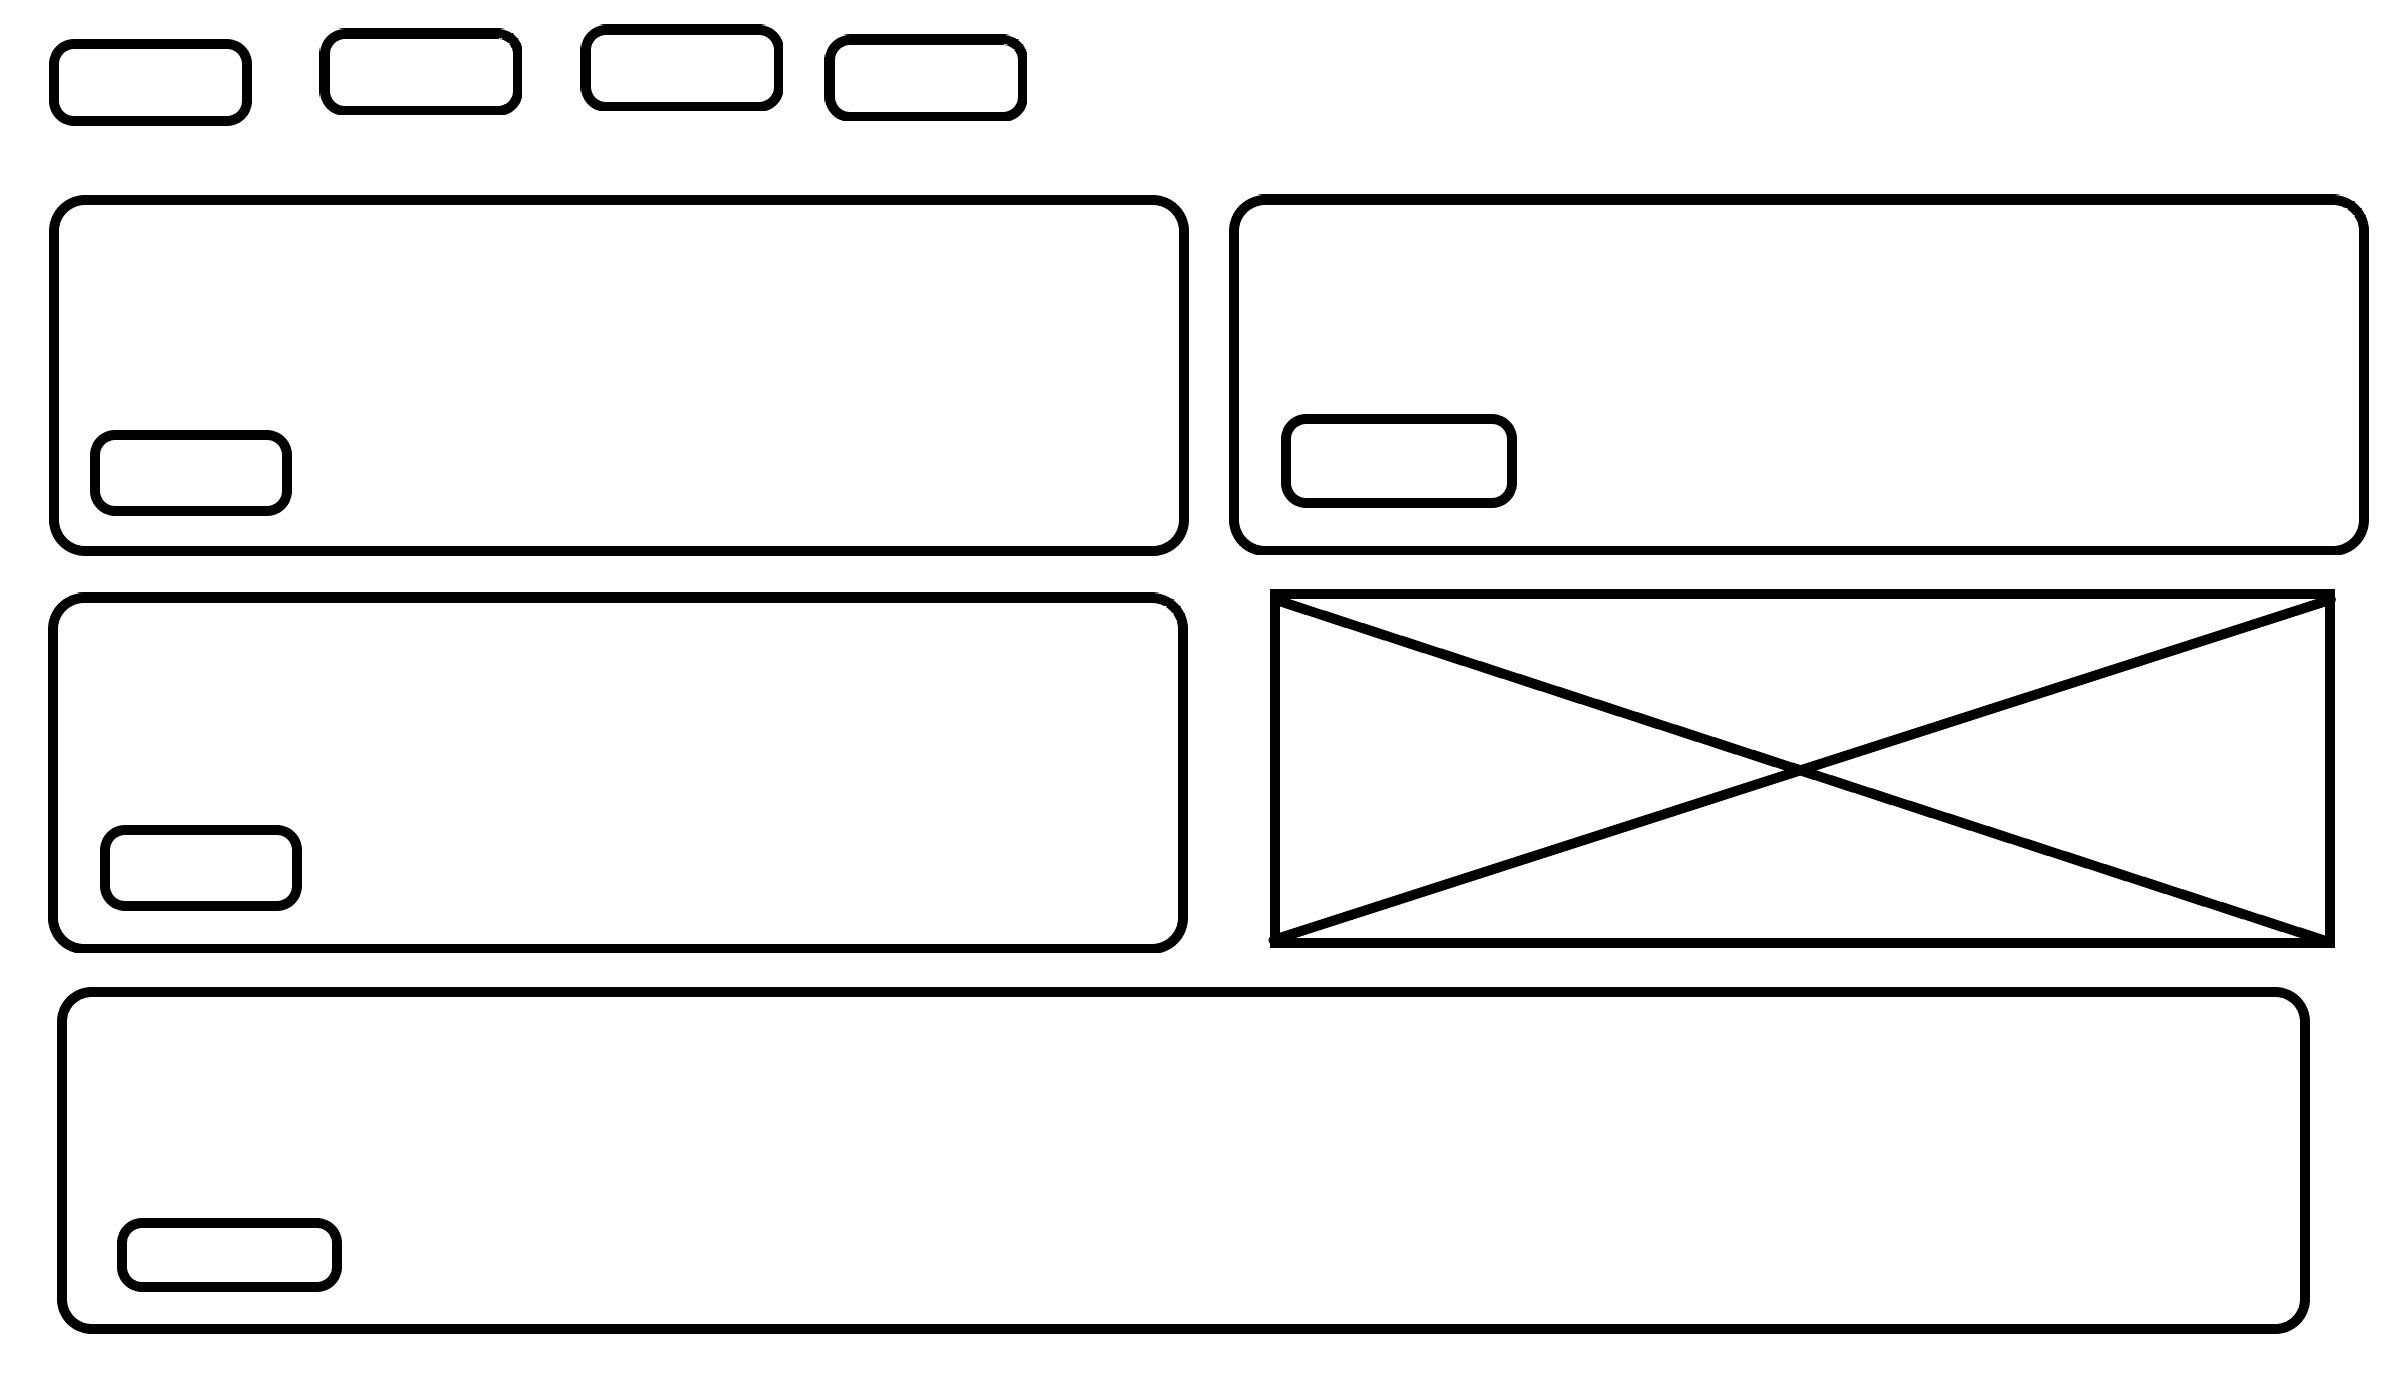

In [60]:
# Change the following variable to test out different results
example_idx = 44
compare_results(predictions[example_idx], targets[example_idx], targets_filepaths[example_idx])